# Neural Machine Translation

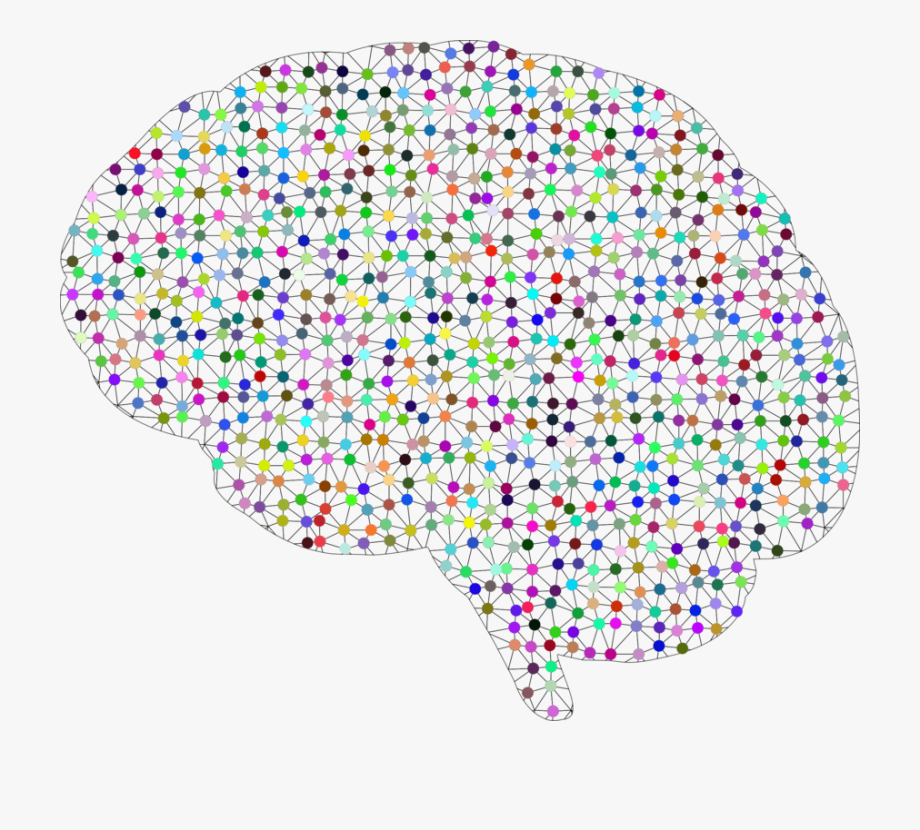

Machine translation is the task of automatically converting source text in one language to text in another language. Given a sequence of text in a source language, there is no one single best translation of that text to another language. This is because of the natural ambiguity and flexibility of human language. This makes the challenge of automatic machine translation difficult, perhaps one of the most difficult in artificial intelligence:

Neural Machine Translation is a machine translation approach that applies a large artificial neural network toward predicting the likelihood of a sequence of words, often in the form of whole sentences. Unlike statistical machine translation, which consumes more memory and time, neural machine translation, NMT, trains its parts end-to-end to maximize performance. NMT systems are quickly moving to the forefront of machine translation, recently outcompeting traditional forms of translation systems.

# How does Neural Machine Translation work?

As referenced above, unlike traditional methods of machine translation that involve separately engineered components, NMT works cohesively to maximize its performance. Additionally, NMT employs the use of vector representations for words and internal state. This means that words are transcribed into a vector defined by a unique magnitude and direction. Compared to phrase-based models, this framework is much simpler. Rather than separate component like the language model and translation model, NMT uses a single sequence model that produces one word at a time.



The NMT uses a bidirectional recurrent neural network, also called an encoder, to process a source sentence into vectors for a second recurrent neural network, called the decoder, to predict words in the target language. This process, while differing from phrase-based models in method, prove to be comparable in speed and accuracy.

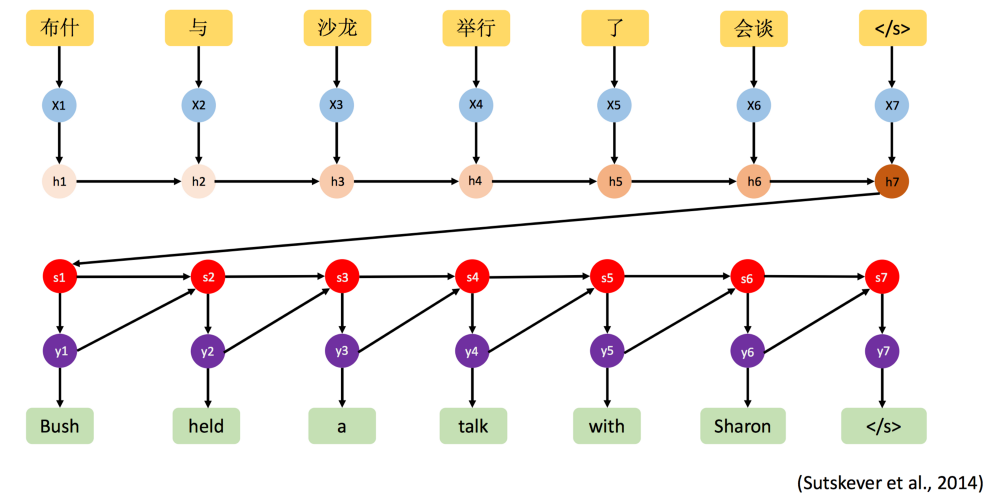

In this above image, chineese language is convereted to English language.

# Applications of Neural Machine Translation

One of the most popular translation machines in the world is Google Translate. The system uses Google Neural Machine Translation to increase its fluency and accuracy. The system not only applies a large data set for training its algorithms, its end-to-end design allows the system to learn over time and create better, more natural translations. Google Neural Machine Translation can even process what are called "zero-shot translations." For example, the translation from French to Spanish is a zero-shot translation because it is a direct translation. Previously, Google Translate would translate the initial language into English, and then translate that English to the target language.


**Here in this notbook, Let's convert Human Readable dates like '8th of April, 2000 ' to Machine Readable format ' 08-04-2000'** 

# Importing Necessary Packages

In [1]:
!pip install faker
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 1.0 MB 2.8 MB/s 


Using TensorFlow backend.


# Generating Dataset

In [2]:
from faker import Faker
fake = Faker()

# We need to seed these guys. For some reason I always use 101
Faker.seed(101)
random.seed(101)

In [3]:
FORMATS = ['short', # d/M/YY
           'medium', # MMM d, YYY
           'medium',
           'medium',
           'long', # MMMM dd, YYY
           'long',
           'long',
           'long',
           'long',
           'full', # EEEE, MMM dd, YYY
           'full',
           'full',
           'd MMM YYY', 
           'd MMMM YYY',
           'd MMMM YYY',
           'd MMMM YYY',
           'd MMMM YYY',
           'd MMMM YYY',
           'dd/MM/YYY',
           'EE d, MMM YYY',
           'EEEE d, MMMM YYY']

Lets have a look at these formats

In [4]:
for format in FORMATS:
    print('%s => %s' %(format, format_date(fake.date_object(), format=format, locale='en')))

short => 7/19/09
medium => Apr 3, 1983
medium => Sep 11, 2006
medium => May 29, 1994
long => October 15, 2001
long => April 20, 1973
long => February 24, 2015
long => April 7, 2004
long => August 6, 1984
full => Monday, December 20, 2010
full => Friday, February 1, 1985
full => Sunday, August 20, 1989
d MMM YYY => 14 Jan 2003
d MMMM YYY => 13 February 2017
d MMMM YYY => 14 June 1984
d MMMM YYY => 23 May 1992
d MMMM YYY => 22 October 1999
d MMMM YYY => 15 October 1974
dd/MM/YYY => 16/05/1987
EE d, MMM YYY => Sat 26, Feb 1983
EEEE d, MMMM YYY => Wednesday 17, December 1980


random_date() will generate a random date using a random format picked from our list FORMATS defined before. It'll return a tuple with the human and machine readable date plus the date object

In [5]:
def random_date():
    dt = fake.date_object()

    try:
        date = format_date(dt, format=random.choice(FORMATS), locale='en')
        human_readable = date.lower().replace(',', '')
        machine_readable = dt.isoformat()

    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt


create_dataset(m) will generate our dataset, taking m as the number of samples to create. It returns the dataset as a list, two dictionaries mapping index to character (these are our vocabularies), human and machine, and the inverse mapping, inv_machine, chars to index:

In [6]:
def create_dataset(m):
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    
    for i in tqdm(range(m)):
        h, m, _ = random_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
    
    # We also add two special chars, <unk> for unknown characters, and <pad> to add padding at the end
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'], list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v: k for k, v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine

Let's generate a dataset with 30k samples. That's probably way too much, but it should do a good job

In [7]:
m = 30000
dataset, human_vocab, machine_vocab, inv_machine_vocab = create_dataset(m)

100%|██████████| 30000/30000 [00:02<00:00, 14426.48it/s]


Inspecting the first 10 entries. Remember it contains a list of tuples => (human readable, machine readable):

In [8]:
dataset[:10]

[('18/01/1976', '1976-01-18'),
 ('april 18 2000', '2000-04-18'),
 ('26 july 2006', '2006-07-26'),
 ('saturday december 10 1994', '1994-12-10'),
 ('15 january 1983', '1983-01-15'),
 ('feb 5 2002', '2002-02-05'),
 ('9 march 1992', '1992-03-09'),
 ('april 2 1986', '1986-04-02'),
 ('sat 18 may 2013', '2013-05-18'),
 ('june 26 1997', '1997-06-26')]

Let's have a look at our human readable vocabulary:

In [9]:
human_vocab

{' ': 0,
 '/': 1,
 '0': 2,
 '1': 3,
 '2': 4,
 '3': 5,
 '4': 6,
 '5': 7,
 '6': 8,
 '7': 9,
 '8': 10,
 '9': 11,
 'a': 12,
 'b': 13,
 'c': 14,
 'd': 15,
 'e': 16,
 'f': 17,
 'g': 18,
 'h': 19,
 'i': 20,
 'j': 21,
 'l': 22,
 'm': 23,
 'n': 24,
 'o': 25,
 'p': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'y': 33,
 '<unk>': 34,
 '<pad>': 35}

Let's have a look at our machine readable vocabulary:

In [10]:
machine_vocab

{'-': 0,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}

Lets have a look at inverse of the machine readable vocabulary

In [11]:
inv_machine_vocab

{0: '-',
 1: '0',
 2: '1',
 3: '2',
 4: '3',
 5: '4',
 6: '5',
 7: '6',
 8: '7',
 9: '8',
 10: '9'}

# Preprocessing

In [12]:
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    X, Y = zip(*dataset)
    
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]
    
    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh

string_to_int(string, length, vocab) will return a list of indexes based on a string and vocabulary, vocab, cropping or padding it depending on the max length passed in:

In [13]:
def string_to_int(string, length, vocab):
    string = string.lower()
    string = string.replace(',','')
    
    if len(string) > length:
        string = string[:length]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
    
    return rep

Let;s see how its working!

In [14]:
string_to_int('April 8th, 2000', 30, human_vocab)

[12,
 26,
 27,
 20,
 22,
 0,
 10,
 29,
 19,
 0,
 4,
 2,
 2,
 2,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35]

In [15]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (30000, 30)
Y.shape: (30000, 10)
Xoh.shape: (30000, 30, 36)
Yoh.shape: (30000, 10, 11)


In [16]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 18/01/1976
Target date: 1976-01-18

Source after preprocessing (indices): [ 3 10  1  2  3  1  3 11  9  8 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35]
Target after preprocessing (indices): [ 2 10  8  7  0  1  2  0  2  9]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


# Define Model

In [17]:
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation('softmax', name='attention_weights')
dotor = Dot(axes = 1)

In [18]:
def one_step_attention(a, s_prev):
    s_prev = repeator(s_prev)
    concat = concatenator([a, s_prev])
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas, a])
    
    return context

In [19]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation='softmax')

In [20]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    outputs = []
    
    a = Bidirectional(LSTM(n_a, return_sequences = True))(X)
    
    for t in range(Ty):
        context = one_step_attention(a, s)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        out = output_layer(s)
        outputs.append(out)
    
    model = Model([X, s0, c0], outputs)
    return model

In [21]:
mod = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [22]:
mod.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 36)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17664       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]               

# Train The Model

In [23]:
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
mod.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))
mod.fit([Xoh, s0, c0], outputs, epochs=20, batch_size=100)

Epoch 1/20
30000/30000 [==============================] - 28s 930us/step - loss: 10.9016 - dense_3_loss: 2.0897 - dense_3_accuracy: 0.9164 - dense_3_accuracy_1: 0.9308 - dense_3_accuracy_2: 0.7136 - dense_3_accuracy_3: 0.3389 - dense_3_accuracy_4: 0.9110 - dense_3_accuracy_5: 0.6062 - dense_3_accuracy_6: 0.3198 - dense_3_accuracy_7: 0.8376 - dense_3_accuracy_8: 0.4285 - dense_3_accuracy_9: 0.2415
Epoch 2/20
30000/30000 [==============================] - 20s 674us/step - loss: 3.8291 - dense_3_loss: 1.1155 - dense_3_accuracy: 0.9907 - dense_3_accuracy_1: 0.9924 - dense_3_accuracy_2: 0.8847 - dense_3_accuracy_3: 0.7858 - dense_3_accuracy_4: 0.9998 - dense_3_accuracy_5: 0.9752 - dense_3_accuracy_6: 0.7719 - dense_3_accuracy_7: 0.9995 - dense_3_accuracy_8: 0.7799 - dense_3_accuracy_9: 0.5855
Epoch 3/20
30000/30000 [==============================] - 20s 675us/step - loss: 2.1922 - dense_3_loss: 0.6046 - dense_3_accuracy: 0.9918 - dense_3_accuracy_1: 0.9933 - dense_3_accuracy_2: 0.8966 - den

# Testing the Model

In [25]:

Example_dates = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in Example_dates:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))
    source = source.reshape((1, ) + source.shape)
    prediction = mod.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output)) 

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-04-05
source: 21th of August 2016
output: 2016-08-01
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


**Hurray!**

We have successfully converted human readable dates to machine readable dates!